In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch.nn as nn
import torch.nn.functional as F

## 数值算例说明
我们设计一个简单的时间序列. states这个向量长度为25, 每个点是可能值为0,1,2的随机数, 在三个值(代表不同模态)之间切换

再把states长度扩展为5000, 具体方法是把原先的25个点每个点重复200次, 这样保证了至少200步才会发生模态间的切换, 保证了切换频率不会过高

接下来再把0,1,2三个状态分别对应到三个不同的二维高斯分布. 把状态0变换到
$$
\mu_0 = \left(\begin{array}{l}
-4\\0
\end{array}
\right),\quad 

\Sigma_0=\left(\begin{array}{ll}
2 & 1.4\\
1.4 & 1.5
\end{array}\right)
$$

状态1变换到
$$
\mu_1 = \left(\begin{array}{l}
4\\-1
\end{array}
\right),\quad 

\Sigma_1=\left(\begin{array}{ll}
2 & -0.95\\
-0.95 & 1
\end{array}\right)
$$

状态2变换到
$$
\mu_2 = \left(\begin{array}{l}
-1\\-3
\end{array}
\right),\quad 

\Sigma_1=\left(\begin{array}{ll}
2 & 0.1\\
0.1 & 0.1
\end{array}\right)
$$


最终向量中各状态的实际数量:
状态 0: 2500
状态 1: 1875
状态 2: 625

最终向量中各状态的实际占比:
状态 0: 50.00%
状态 1: 37.50%
状态 2: 12.50%


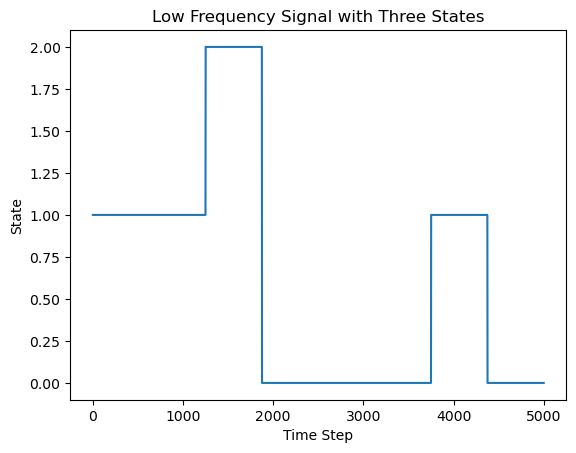

In [50]:
# 创建一个时间序列, 大致是在三个状态之间转换, 并控制转换的频率
torch.manual_seed(61)
n_steps = 5000

# 状态切换的次数, 意味着扩展成n_steps个点后, 大约会有num_segments次状态切换, 保证了每段至少有n_steps/num_segments个点
num_segments = 8

# 定义三个状态的权重(占比)
weights = torch.tensor([1.0, 1.0, 1.0])

# 根据weights的权重比例随机抽取num_segments个样本
low_frequency_signal = torch.multinomial(weights, num_segments, replacement=True)

# "拉伸"states, 使每段有n_steps/num_segments个点
segment_length = n_steps // num_segments
states = torch.repeat_interleave(low_frequency_signal, segment_length)

# 如果有余数，用最后一个状态的值填充，确保总长度为n_steps
remainder = n_steps % num_segments
if remainder != 0:
    states = torch.cat([states, torch.full((remainder,), int(low_frequency_signal[-1]))])


#   计算每个状态的实际数量和占比
actual_counts = torch.bincount(states, minlength=3) 
print("\n最终向量中各状态的实际数量:")
print(f"状态 0: {actual_counts[0].item()}")
print(f"状态 1: {actual_counts[1].item()}")
print(f"状态 2: {actual_counts[2].item()}")

actual_proportions = actual_counts.float() / n_steps
print("\n最终向量中各状态的实际占比:")
print(f"状态 0: {actual_proportions[0].item():.2%}")
print(f"状态 1: {actual_proportions[1].item():.2%}")
print(f"状态 2: {actual_proportions[2].item():.2%}")

plt.plot(states.numpy())
plt.title("Low Frequency Signal with Three States")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.show()

In [51]:
mu_0 = torch.tensor([-4,0], dtype=torch.float32)
sigma_0 = torch.tensor([[2,1.4],[1.4,1.5]], dtype=torch.float32)

mu_1 = torch.tensor([4,-1], dtype=torch.float32)
sigma_1 = torch.tensor([[2,-0.95],[-0.95,1]], dtype=torch.float32)

mu_2 = torch.tensor([-1,-3], dtype=torch.float32)
sigma_2 = torch.tensor([[2,0.1],[0.1,0.1]], dtype=torch.float32)

In [52]:
torch.manual_seed(61)

dist_0 = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=sigma_0)
dist_1 = torch.distributions.MultivariateNormal(loc=mu_1, covariance_matrix=sigma_1)
dist_2 = torch.distributions.MultivariateNormal(loc=mu_2, covariance_matrix=sigma_2)


torch.manual_seed(101) # 使用一个不同的种子

# 创建一个空的张量来存放最终结果
Xt = torch.empty(n_steps, 2, dtype=torch.float32)

# 使用布尔掩码(boolean masking)进行高效采样和赋值，避免使用for循环
# 1. 找出状态为0的所有位置
mask_0 = (states == 0)
# 2. 在这些位置上，填充从第一个分布中抽取的样本
#    mask_0.sum() 会计算出需要抽取多少个样本
Xt[mask_0] = dist_0.sample((mask_0.sum(),))

# 对状态1和状态2重复此操作
mask_1 = (states == 1)
Xt[mask_1] = dist_1.sample((mask_1.sum(),))

mask_2 = (states == 2)
Xt[mask_2] = dist_2.sample((mask_2.sum(),))


print("最终输出的维度:", Xt.shape)

最终输出的维度: torch.Size([5000, 2])


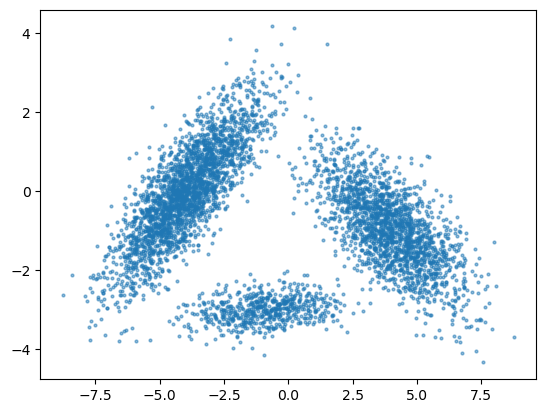

In [53]:
plt.plot(Xt[:,0], Xt[:,1], 'o', markersize=2, alpha=0.5)

In [54]:
# Random Fourier Feature

def sample_rff_gaussian(d, p, sigma):
    """ Draw a sample from the spectral density for a Gaussian kernel.
    Parameters:
    -----------
    d, int:         dimension of the state space for Gaussian kernel
    p, int:         number of samples from spectral density
    sigma, float:   bandwidth of the Gaussian kernel

    Returns:
    --------
    Omega (d, p):   p samples drawn from d-dimensional spectral density

    """

    return (1.0 / sigma) * np.random.randn(d, p)


def M_RFF_Koopman(X, Omega):
    
    phase = np.dot(X, Omega)  # shape: (n_steps, p)
    
    # 分别计算RFF的实部和虚部
    cos_features = np.cos(phase)  # shape: (n_steps, p)
    sin_features = np.sin(phase)  # shape: (n_steps, p)
    
    M = np.hstack([cos_features, sin_features])  # shape: (n_steps, 2*p)
    
    return M.T


In [55]:
# 用RFF变换Xt
d = Xt.shape[1]
p = 20   # RFF的基函数个数
sigma = 2

omega = sample_rff_gaussian(d, p, sigma)
transformed_Xt = M_RFF_Koopman(Xt, omega)

print(transformed_Xt.shape)  # (2*p, n_steps)

(40, 5000)


In [56]:
# PCA Whitening, 加入特征函数1(x)

from scipy.linalg import eigh

def whitening_transform_pca(PhiX, tol, rmin=0):
    
    # centering the data
    
    mean_vec = np.mean(PhiX, axis=1, keepdims=True)
    X_centered = PhiX - mean_vec
    
    
    # covariance matrix
    cov_matrix = np.cov(X_centered)  
    
    # eigen decomposition
    eigenvalues, eigenvectors = eigh(cov_matrix)
    
    # sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # truncation
    ind = np.where(eigenvalues / eigenvalues[0] >= tol**2)[0]
    r = np.maximum(len(ind), rmin)
    
    selected_eigenvalues = eigenvalues[:r]
    selected_eigenvectors = eigenvectors[:, :r]
    
    # Whitening matrix
    L = selected_eigenvectors * (selected_eigenvalues**(-0.5))[None, :]
    
    return L, mean_vec

# 进行PCA Whitening
L_pca, mean_pca = whitening_transform_pca(transformed_Xt, tol=1e-4, rmin=0)
whitened_Xt = L_pca.T @ (transformed_Xt - mean_pca)

print(whitened_Xt.shape)  # (r, 10000)

(36, 5000)


In [57]:
# 验证协方差矩阵
cov_original = np.cov(transformed_Xt)
cov_whitened = np.cov(whitened_Xt)

print("RFF后协方差矩阵阶数: ", cov_original.shape)
print("白化变换后协方差矩阵阶数: ", cov_whitened.shape)

print("协方差矩阵对角线元素:", np.diag(cov_whitened))
print("协方差矩阵非对角线元素最大值:", np.max(np.abs(cov_whitened - np.diag(np.diag(cov_whitened)))))

RFF后协方差矩阵阶数:  (40, 40)
白化变换后协方差矩阵阶数:  (36, 36)
协方差矩阵对角线元素: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
协方差矩阵非对角线元素最大值: 7.553918887128097e-11


In [58]:
# 加入特征函数1(x)
first_feature = np.ones(whitened_Xt.shape[1])
whitened_Xt = np.vstack([first_feature, whitened_Xt])
whitened_Xt.shape

(37, 5000)

In [59]:
# 定义L, gamma以及损失函数

class nonstation_generator(nn.Module):
    def __init__(self, n_features, n_steps, K, hidden_dim=64):
        super().__init__()
        
        self.n_features = n_features
        self.n_steps = n_steps
        self.K = K
        
        # generator function L
        self.L = nn.Parameter(
            torch.randn(K, n_features, n_features)  
        )
        
        # affiliation function gamma(t) 
        self.gamma_network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, K)
        )   
        
    def init_gamma_from_prior(self, prior_gamma, lr=1e-3, max_iter=300):
        """
        使用先验gamma微调gamma_network
        
        Args:
            prior_gamma: 先验的gamma值 (K, n_steps)
            lr: 学习率
            max_iter: 最大迭代次数
        """
        prior_gamma = torch.tensor(prior_gamma, dtype=torch.float32)
        time_points = torch.linspace(0, 1, self.n_steps).unsqueeze(-1)
        
        # 只优化gamma_network
        optimizer = torch.optim.Adam(self.gamma_network.parameters(), lr=lr)
        
        for iteration in range(max_iter):
            optimizer.zero_grad()
            
            # 前向传播
            gamma_logits = self.gamma_network(time_points)
            gamma_pred = F.softmax(gamma_logits, dim=-1).T
            
            # 计算MSE损失
            loss = F.mse_loss(gamma_pred, prior_gamma)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            # 打印损失
            if iteration % 100 == 0:
                print(f"初始化迭代 {iteration}: Loss = {loss.item():.6f}")      
    
    def forward(self):

        L = self.L
        
        time_points = torch.linspace(0, 1, self.n_steps).unsqueeze(-1)  # (n_steps, 1)
        gamma_logits = self.gamma_network(time_points)  # (n_steps, K)
        gamma = F.softmax(gamma_logits, dim=-1).T  
        
        return L, gamma

def koopman_loss_function(whitened_Xt, L, gamma, epsilon_gamma, epsilon_L):
    
    n_features, n_steps = whitened_Xt.shape
    K = L.shape[0]
    
    # 计算phi(x_n)和phi(x_n+1)
    phi_t = whitened_Xt[:, :-1]   # (n_features, n_steps-1)
    phi_t1 = whitened_Xt[:, 1:]   # (n_features, n_steps-1)
    
    phi_t_batch = phi_t.T.unsqueeze(0).expand(K, -1, -1)      # (K, n_steps-1, n_features)
    phi_t1_batch = phi_t1.T.unsqueeze(0).expand(K, -1, -1)    # (K, n_steps-1, n_features)
    
    predictions = torch.bmm(phi_t_batch, L)  # (K, n_steps-1, n_features)*(K, n_features, n_features) -> (K, n_steps-1, n_features)
    
    # norm(phi_n+1, L*phi_n)
    errors = phi_t1_batch - predictions
    squared_errors = torch.sum(errors**2, dim=-1)  # (K, n_steps-1)
    
    # \|\phi(x_{n+1})-L\phi(x_n)\|^2
    main_loss = (1/(n_steps-1)) * torch.sum(squared_errors * gamma[:, :-1])
    
    # 正则化项
    smoothness_loss = epsilon_gamma * (1/(n_steps-1)) * torch.sum((gamma[:, 1:] - gamma[:, :-1])**2)
    generator_loss = epsilon_L * torch.norm(L, p='fro')**2
    
    return main_loss + smoothness_loss + generator_loss

def train_koopman_model(whitened_Xt, K, prior_gamma=None, 
                        max_iter=1000, lr=1e-3, 
                        epsilon_gamma=0.01, epsilon_L=0.1,
                        init_lr=0.01, init_max_iter=500):
    
    whitened_Xt = torch.tensor(whitened_Xt, dtype=torch.float32)
    
    # 初始化模型
    n_features, n_steps = whitened_Xt.shape
      
    model = nonstation_generator(n_features, n_steps, K)
    
    # 如果提供先验gamma，进行初始化
    if prior_gamma is not None:
        print("使用先验gamma进行初始化...")
        model.init_gamma_from_prior(
            prior_gamma, 
            lr=init_lr, 
            max_iter=init_max_iter
        )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 训练
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # 前向传播得到L和gamma(t)
        L, gamma = model()
        
        # 计算损失
        loss = koopman_loss_function(whitened_Xt, L, gamma, 
                                     epsilon_gamma=epsilon_gamma, 
                                     epsilon_L=epsilon_L)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if iteration % 200 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item():.6f}")
            
    
    return L.detach().numpy(), gamma.detach().numpy()


    

/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 30828 (\N{CJK UNIFIED IDEOGRAPH-786C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3748/1790717932.py:66: UserWarning: Glyph 30028 (\N{CJK UNIFIED IDEOGRAPH-754C}) missing from current font.
  plt.tight_l

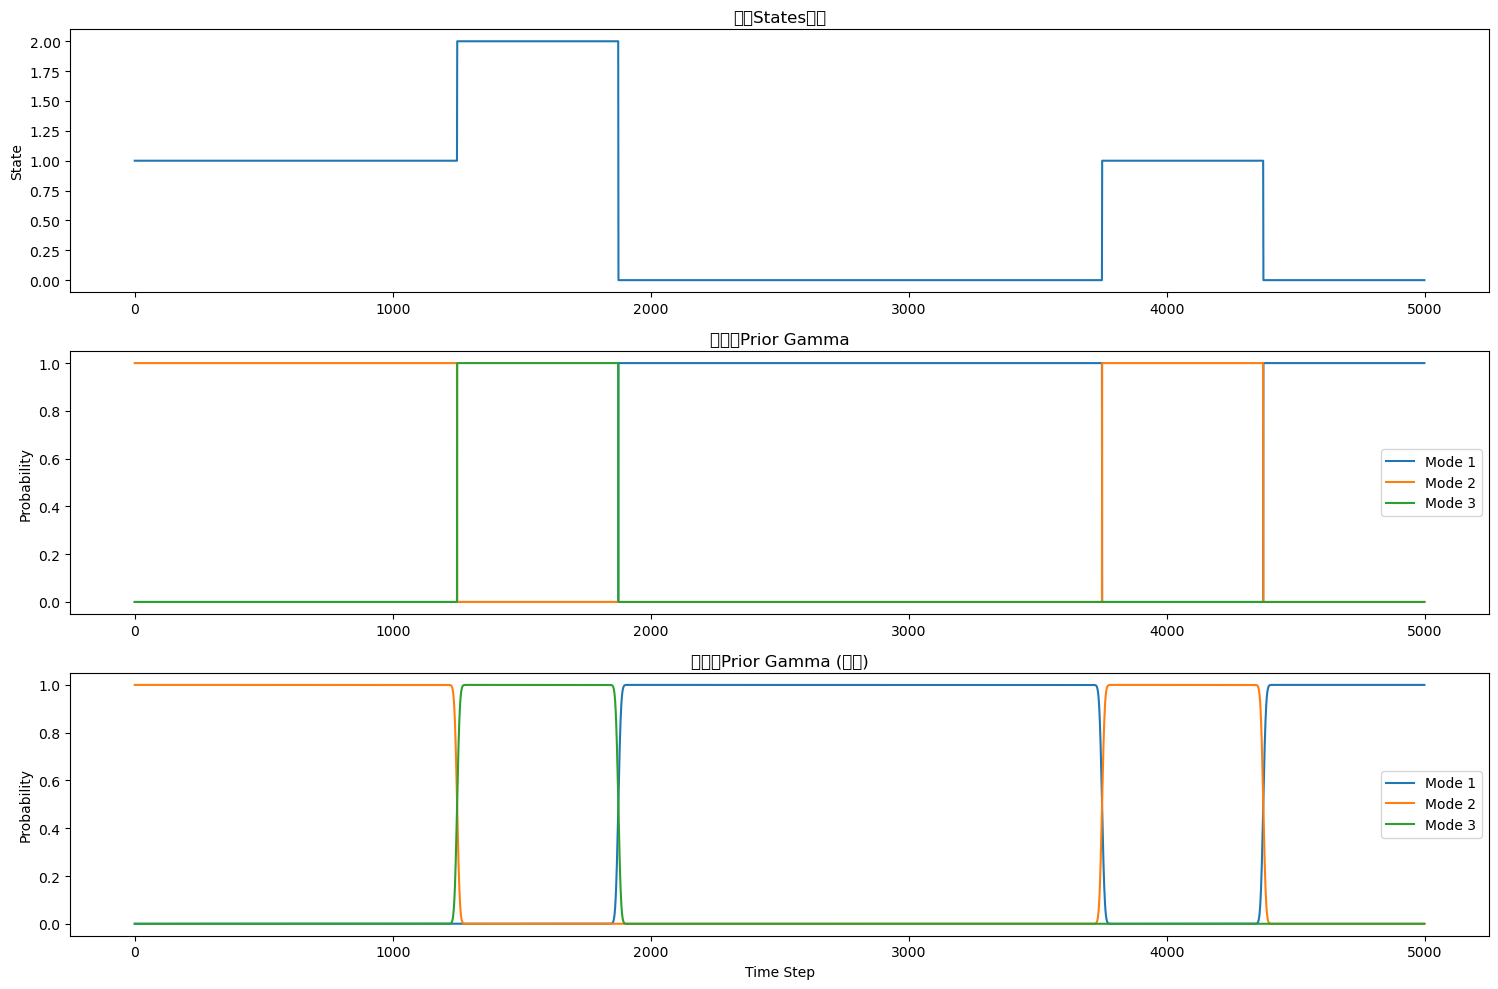

In [60]:
# 把states向量转换为prior_gamma
# 但这样的话只是$K=3$的情况, 如果$K$是其它值是不是就做不了这件事?
def states_to_prior_gamma(states, K=3, smoothing_window=50):
    """
    将状态向量转换为prior_gamma
    
    Args:
        states: 状态向量 (n_steps,)
        K: 状态数量
        smoothing_window: 平滑窗口大小，用于软化硬边界
    
    Returns:
        prior_gamma: (K, n_steps) 的先验gamma矩阵
    """
    n_steps = len(states)
    
    # 创建one-hot编码
    prior_gamma = torch.zeros(K, n_steps)
    for t in range(n_steps):
        prior_gamma[states[t], t] = 1.0
    
    # 应用高斯平滑来软化硬边界
    if smoothing_window > 1:
        from scipy.ndimage import gaussian_filter1d
        sigma = smoothing_window / 6.0  # 经验值
        
        for k in range(K):
            prior_gamma[k, :] = torch.tensor(
                gaussian_filter1d(prior_gamma[k, :].numpy(), sigma=sigma)
            )
        
        # 重新归一化
        prior_gamma = prior_gamma / prior_gamma.sum(dim=0, keepdim=True)
    
    return prior_gamma.numpy()


# 以$K=3$为例转换为prior_gamma
K = 3
prior_gamma_hard = states_to_prior_gamma(states, K=K, smoothing_window=1)  # 硬边界
prior_gamma_soft = states_to_prior_gamma(states, K=K, smoothing_window=50)  # 软边界

# 可视化比较
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 原始states
axes[0].plot(states.numpy())
axes[0].set_title("原始States向量")
axes[0].set_ylabel("State")

# hard prior_gamma
for k in range(K):
    axes[1].plot(prior_gamma_hard[k, :], label=f'Mode {k+1}')
axes[1].set_title("硬边界Prior Gamma")
axes[1].set_ylabel("Probability")
axes[1].legend()

# 软边界prior_gamma
for k in range(K):
    axes[2].plot(prior_gamma_soft[k, :], label=f'Mode {k+1}')
axes[2].set_title("软边界Prior Gamma (平滑)")
axes[2].set_ylabel("Probability")
axes[2].set_xlabel("Time Step")
axes[2].legend()

plt.tight_layout()
plt.show()



In [61]:
# 对不同的$K$进行测试

def explore_different_k(whitened_Xt, 
                        K_range=[3, 4, 5], 
                        max_iter=8000, 
                        epsilon_gamma=0.001, 
                        epsilon_L=0.1,
                        prior_gamma=None
                        ):
    
    results = {}
    
    for K in K_range:
        print(f"\n K = {K}")
        
        prior_gamma = prior_gamma.get(K, None) if prior_gamma else None
        
        # 训练模型
        L, gamma = train_koopman_model(
            whitened_Xt, 
            K=K, 
            prior_gamma=prior_gamma,
            max_iter=max_iter,
            epsilon_gamma=epsilon_gamma,
            epsilon_L=epsilon_L
        )
        
        # 计算损失
        loss = koopman_loss_function(
            torch.tensor(whitened_Xt, dtype=torch.float32), 
            torch.tensor(L, dtype=torch.float32), 
            torch.tensor(gamma, dtype=torch.float32), 
            epsilon_gamma=epsilon_gamma, 
            epsilon_L=epsilon_L
        )
        
        # 存储结果
        results[K] = {
            'L': L,
            'gamma': gamma,
            'loss': loss.item()
        }
        
        # 可视化gamma(t)
        plt.figure(figsize=(12, 4))
        plt.title(f'Gamma(t) for K = {K} (Loss: {loss.item():.4f})')
        for k in range(K):
            plt.plot(gamma[k, :], label=f'Mode {k+1}')
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel('Affiliation')
        plt.show()
    
    return results


 K = 3
使用先验gamma进行初始化...
初始化迭代 0: Loss = 0.209234
初始化迭代 100: Loss = 0.072293
初始化迭代 200: Loss = 0.065299
初始化迭代 300: Loss = 0.065195
初始化迭代 400: Loss = 0.063381
Iteration 0: Loss = 1812.832275
Iteration 200: Loss = 1221.600464
Iteration 400: Loss = 840.821655
Iteration 600: Loss = 593.010681
Iteration 800: Loss = 428.735657
Iteration 1000: Loss = 318.205719
Iteration 1200: Loss = 242.482422
Iteration 1400: Loss = 189.511627
Iteration 1600: Loss = 151.614227
Iteration 1800: Loss = 123.881912
Iteration 2000: Loss = 103.162216
Iteration 2200: Loss = 87.408066
Iteration 2400: Loss = 75.269531
Iteration 2600: Loss = 65.834778


Iteration 2800: Loss = 58.468674
Iteration 3000: Loss = 52.712833
Iteration 3200: Loss = 48.224648
Iteration 3400: Loss = 44.740009
Iteration 3600: Loss = 42.050674
Iteration 3800: Loss = 39.990013
Iteration 4000: Loss = 38.423847
Iteration 4200: Loss = 37.243896
Iteration 4400: Loss = 36.362759
Iteration 4600: Loss = 35.706314
Iteration 4800: Loss = 35.209141
Iteration 5000: Loss = 34.860157
Iteration 5200: Loss = 34.613308
Iteration 5400: Loss = 34.438953
Iteration 5600: Loss = 34.316330
Iteration 5800: Loss = 34.230518
Iteration 6000: Loss = 34.170635
Iteration 6200: Loss = 34.129726
Iteration 6400: Loss = 34.102016
Iteration 6600: Loss = 34.083534
Iteration 6800: Loss = 34.071487
Iteration 7000: Loss = 34.063850
Iteration 7200: Loss = 34.059166
Iteration 7400: Loss = 34.056381
Iteration 7600: Loss = 34.054779
Iteration 7800: Loss = 34.053871


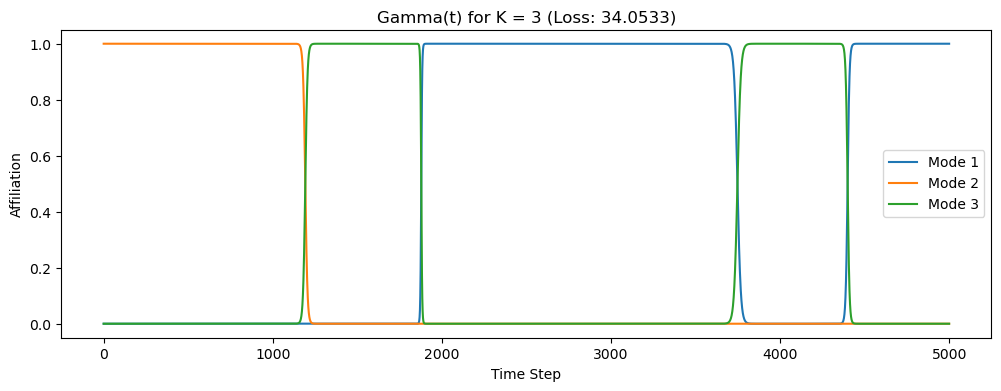

In [62]:
results = explore_different_k(
    whitened_Xt, 
    K_range=[3],  # 只使用K=3
    prior_gamma={3: states_to_prior_gamma(states)}
)

## Finite Element Method计算gamma_t